<a href="https://colab.research.google.com/github/debashisdotchatterjee/-A-Generalized-P-lya-Urn-Model-with-Interaction-Dependent-Reinforcement/blob/main/Polya_the_balanced_regime_CLT_diagnostics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Python — complete, working script

Saves all figures/tables under urn_outputs/ and also displays them.

Produces:
balanced_paths.png, balanced_qq.png, balanced_violin.png,
balanced_Sigma_emp.png, balanced_Sigma_th.png,
balanced_summary.tex, superlinear_phase.png, superlinear_phase.tex.

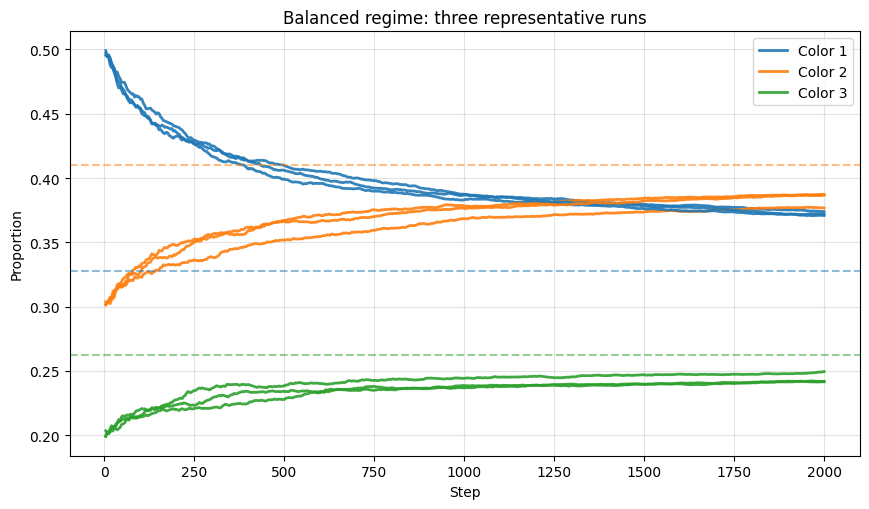

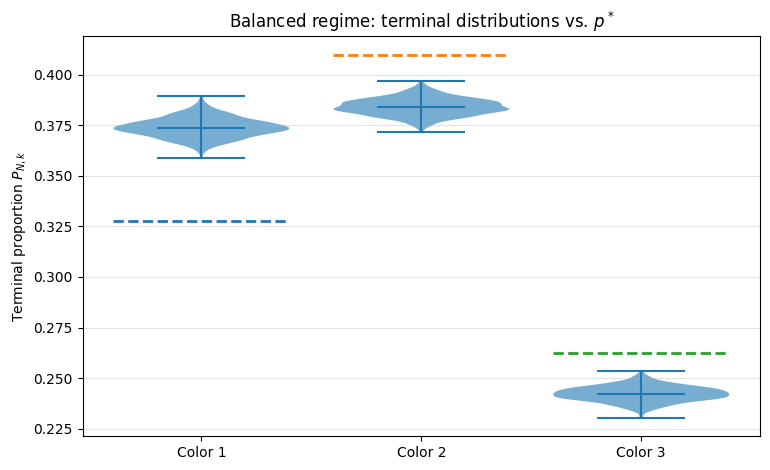

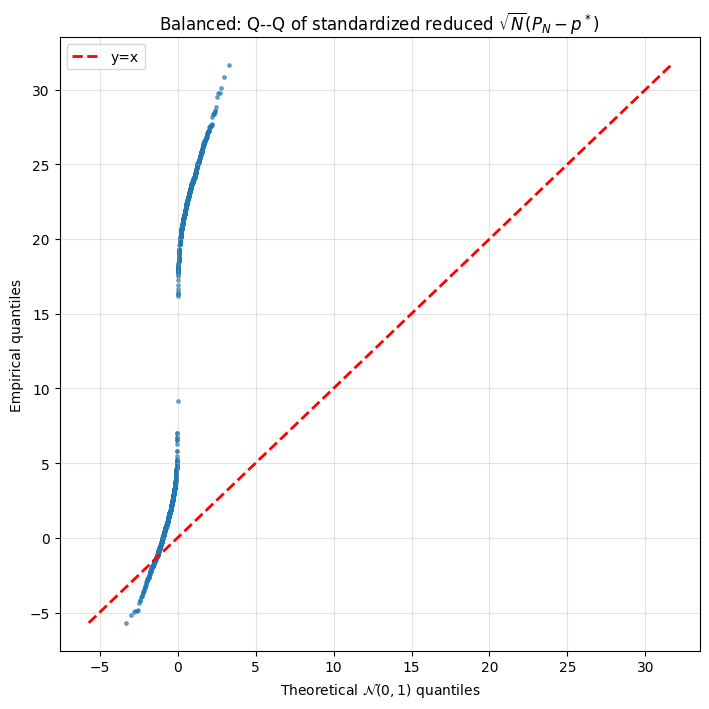

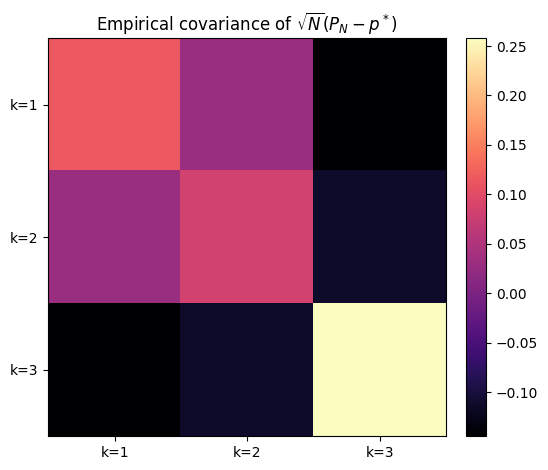

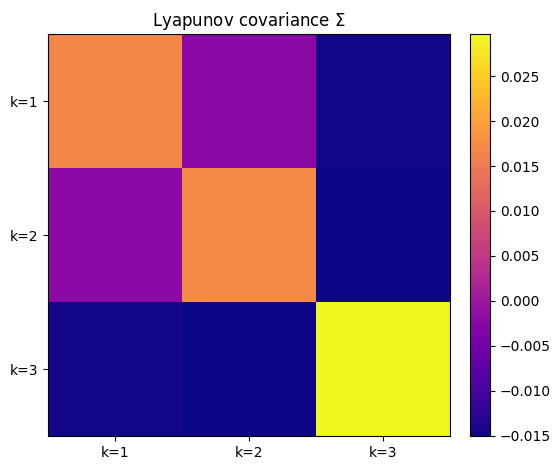

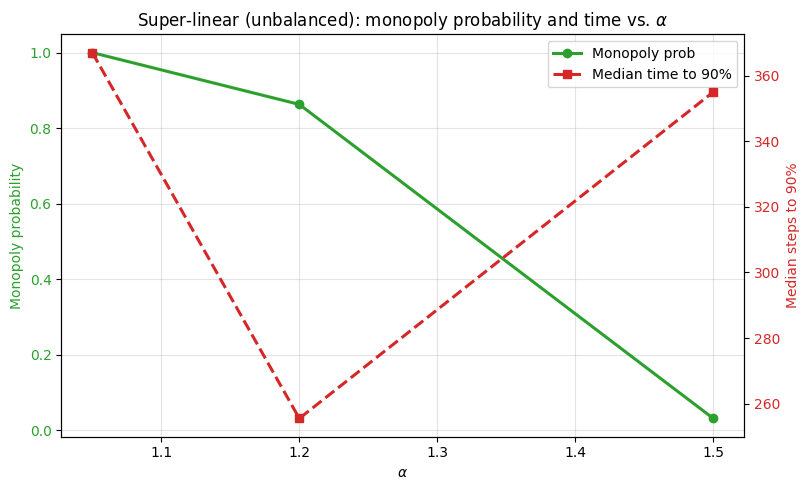

Wrote figures and tables to: urn_outputs1


In [ ]:
# ============================================================
#  Interacting Pólya urns: balanced CLT + super-linear phase
#  - Figures + LaTeX tables to ./urn_outputs
#  - Displays plots inline too
#  - Pure NumPy/Matplotlib (no SciPy)
# ============================================================

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import solve, norm, eig
from statistics import NormalDist

OUT = "urn_outputs1"
os.makedirs(OUT, exist_ok=True)
rng = np.random.default_rng(42)

# ---------- Helpers ----------
def stationary_of_row_stochastic(B, tol=1e-12, maxit=10000):
    """Right eigenvector of B^T with eigenvalue 1, normalized to 1-sum."""
    K = B.shape[0]
    p = np.ones(K)/K
    for _ in range(maxit):
        p_new = B.T @ p
        p_new = p_new / p_new.sum()
        if norm(p_new - p, 1) < tol:
            return p_new
        p = p_new
    return p

def simulate_balanced(A, c, s, X0, N, R, sample_paths=3, seed=1):
    """Balanced rule: Delta_i(p) = A[i] + c p, with sum_k Delta_i,k = s."""
    rg = np.random.default_rng(seed)
    K = len(X0)
    P_final = np.zeros((R, K))
    # choose some runs to save full paths
    idxs = rg.choice(R, size=sample_paths, replace=False)
    paths = {int(i): [] for i in idxs}

    for r in range(R):
        X = X0.astype(float).copy()
        for n in range(1, N+1):
            p = X/X.sum()
            i = rg.choice(K, p=p)
            d = A[i] + c*p
            # exact balancedness already holds: sum(d)=s
            X += d
            if r in paths and (n % max(1, N//500) == 0):
                paths[r].append((n, *list(X/X.sum())))
        P_final[r] = X/X.sum()
    # stack saved paths
    for k in list(paths.keys()):
        paths[k] = np.array(paths[k])
    return P_final, paths

def lyapunov_on_tangent(J_full, Q_full):
    """Project to tangent space sum=0 via M=[e1-eK, e2-eK,...],
       solve J_red Σ_red + Σ_red J_red^T + Q_red = 0, and lift back."""
    K = J_full.shape[0]
    # basis matrix M: columns are e_j - e_K for j=1..K-1
    M = np.zeros((K, K-1))
    for j in range(K-1):
        M[j, j] = 1.0
        M[K-1, j] = -1.0
    J_red = M.T @ J_full @ M
    Q_red = M.T @ Q_full @ M
    # Solve Lyapunov via vec trick: (I⊗J + J⊗I) vec(Σ) = -vec(Q)
    A = np.kron(np.eye(K-1), J_red) + np.kron(J_red, np.eye(K-1))
    vecQ = Q_red.reshape(-1)
    vecS = -solve(A, vecQ)
    S_red = vecS.reshape(K-1, K-1)
    # lift:
    S_full = M @ S_red @ M.T
    return S_full, S_red, M

def heatmap(M, title, fname, cmap="viridis"):
    plt.figure(figsize=(5.8,4.8))
    im = plt.imshow(M, cmap=cmap)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(title)
    plt.xticks(range(M.shape[1]), [f"k={i+1}" for i in range(M.shape[1])])
    plt.yticks(range(M.shape[0]), [f"k={i+1}" for i in range(M.shape[0])])
    plt.tight_layout(); plt.show()
    plt.savefig(os.path.join(OUT, fname), dpi=180, bbox_inches="tight")
    plt.close()

# ---------- Parameters (balanced) ----------
K = 3
s = 1.0
c = 0.35
B = np.array([[0.55, 0.30, 0.15],
              [0.20, 0.60, 0.20],
              [0.25, 0.25, 0.50]])
A = (s - c) * B
X0 = np.array([50., 30., 20.])
N  = 2000
R  = 500

# Equilibrium p*
pstar = stationary_of_row_stochastic(B)

# Simulate balanced
P_final, paths = simulate_balanced(A, c, s, X0, N, R, sample_paths=3, seed=17)

# ---------- Balanced plots ----------
# (1) 3 representative paths
plt.figure(figsize=(8.8,5.2))
colors = ["#1f77b4","#ff7f0e","#2ca02c"]
for ridx, arr in paths.items():
    for k in range(K):
        plt.plot(arr[:,0], arr[:,k+1], lw=2, alpha=0.9, color=colors[k],
                 label=(f"Color {k+1}" if ridx==list(paths.keys())[0] else None))
plt.axhline(pstar[0], color=colors[0], ls="--", alpha=0.5)
plt.axhline(pstar[1], color=colors[1], ls="--", alpha=0.5)
plt.axhline(pstar[2], color=colors[2], ls="--", alpha=0.5)
plt.title("Balanced regime: three representative runs")
plt.xlabel("Step"); plt.ylabel("Proportion")
plt.grid(alpha=0.35); plt.legend()
plt.tight_layout(); plt.show()
plt.savefig(os.path.join(OUT, "balanced_paths.png"), dpi=180, bbox_inches="tight")
plt.close()

# (2) Violin of terminal P_N vs p*
plt.figure(figsize=(7.8,4.8))
parts = plt.violinplot([P_final[:,0], P_final[:,1], P_final[:,2]],
                       positions=[1,2,3], showmeans=True, widths=0.8)
for pc in parts['bodies']:
    pc.set_alpha(0.6)
plt.xticks([1,2,3],[f"Color {k+1}" for k in range(K)])
for k, col in enumerate(colors):
    plt.hlines(pstar[k], k+0.6, k+1.4, color=col, ls="--", lw=2)
plt.ylabel("Terminal proportion $P_{N,k}$")
plt.title("Balanced regime: terminal distributions vs. $p^*$")
plt.grid(axis="y", alpha=0.35)
plt.tight_layout(); plt.show()
plt.savefig(os.path.join(OUT, "balanced_violin.png"), dpi=180, bbox_inches="tight")
plt.close()

# ---------- CLT objects (balanced) ----------
# Theoretical quantities
J_full = A.T - (s - c)*np.eye(K)    # constant Jacobian of h(p)
# Noise at p*: Xi = Δ_i(p*) - r, with prob p*_i
Delta_at_p = np.array([A[i] + c*pstar for i in range(K)])
r = (pstar[:,None] * Delta_at_p).sum(axis=0)
Q_full = (pstar[:,None,None] * np.einsum("ik,ij->ikj", Delta_at_p, Delta_at_p)).sum(axis=0) - np.outer(r,r)

Sigma_th_full, Sigma_th_red, M = lyapunov_on_tangent(J_full, Q_full)

# Empirical Σ from reduced coordinates (avoid singularity)
Z_full = np.sqrt(N) * (P_final - pstar)
Z_red  = Z_full @ M   # R x (K-1)
Sigma_emp_red = np.cov(Z_red.T, bias=False)
Sigma_emp_full = M @ Sigma_emp_red @ M.T

# (3) Q--Q in reduced standardized coords
# whiten via Cholesky (2x2); if not PD, fallback to diagonal
try:
    from numpy.linalg import cholesky
    L = cholesky(Sigma_th_red + 1e-12*np.eye(K-1))
    Zstd = (Z_red @ np.linalg.inv(L).T).reshape(-1)
except Exception:
    sd = np.sqrt(np.maximum(np.diag(Sigma_th_red), 1e-12))
    Zstd = (Z_red / sd).reshape(-1)

Zs = np.sort(Zstd)
q  = np.linspace(0.5/len(Zs), 1-0.5/len(Zs), len(Zs))
theo = np.array([NormalDist().inv_cdf(val) for val in q])

plt.figure(figsize=(7.2,7.2))
plt.scatter(theo, Zs, s=6, alpha=0.6, color="#1f77b4")
lo, hi = float(min(theo.min(), Zs.min())), float(max(theo.max(), Zs.max()))
plt.plot([lo,hi],[lo,hi], 'r--', lw=2, label="y=x")
plt.title(r"Balanced: Q--Q of standardized reduced $\sqrt{N}(P_N-p^*)$")
plt.xlabel(r"Theoretical $\mathcal{N}(0,1)$ quantiles"); plt.ylabel("Empirical quantiles")
plt.grid(alpha=0.35); plt.legend()
plt.tight_layout(); plt.show()
plt.savefig(os.path.join(OUT, "balanced_qq.png"), dpi=180, bbox_inches="tight")
plt.close()

# (4) Covariance heatmaps (full KxK)
heatmap(Sigma_emp_full, r"Empirical covariance of $\sqrt{N}(P_N-p^*)$", "balanced_Sigma_emp.png", cmap="magma")
heatmap(Sigma_th_full,  r"Lyapunov covariance $\Sigma$",               "balanced_Sigma_th.png",  cmap="plasma")

# Coverage check (per coordinate, using theoretical variances)
cov_95 = []
for k in range(K):
    sd_k = np.sqrt(max(Sigma_th_full[k,k], 1e-12))
    z = Z_full[:,k]/sd_k
    cov_95.append(float(np.mean(np.abs(z) <= 1.96)))

fro_err = norm(Sigma_emp_full - Sigma_th_full, ord="fro")

# Save LaTeX summary table
summary_df = pd.DataFrame([{
    "K": K, "R": R, "N": N,
    "p*_1": pstar[0], "p*_2": pstar[1], "p*_3": pstar[2],
    "Frobenius ||Σ_emp-Σ||": fro_err,
    "Coverage 95% k=1": cov_95[0],
    "Coverage 95% k=2": cov_95[1],
    "Coverage 95% k=3": cov_95[2]
}])
with open(os.path.join(OUT,"balanced_summary.tex"), "w") as f:
    f.write(summary_df.to_latex(index=False, float_format="%.4f"))

# ---------- Super-linear, unbalanced ----------
def simulate_superlinear(alpha, X0, N, R, scale=0.01, cap=5.0, thr=0.9, seed=2024):
    rg = np.random.default_rng(seed)
    K = len(X0)
    dom_count = 0
    times = []
    for r in range(R):
        X = X0.astype(float).copy()
        t_hit = None
        for n in range(1, N+1):
            p = X/X.sum()
            i = rg.choice(K, p=p)
            d = np.zeros(K)
            d[i] = min(scale * (X[i]**alpha), cap)  # pure self-reinforcement, capped
            X += d
            if t_hit is None and (X/X.sum()).max() > thr:
                t_hit = n
                # keep going to stabilize proportions slightly (optional)
        if t_hit is not None:
            dom_count += 1
            times.append(t_hit)
    prob = dom_count / R
    med_time = float(np.median(times)) if times else np.nan
    return prob, med_time

alphas = [1.05, 1.20, 1.50]
R2, N2 = 350, 800
prob_list, med_list = [], []
for a in alphas:
    pr, mt = simulate_superlinear(a, X0, N2, R2, scale=0.01, cap=5.0, thr=0.9, seed=101+int(100*a))
    prob_list.append(pr); med_list.append(mt)

# Compose phase plot (prob + median time)
fig, ax1 = plt.subplots(figsize=(8.2,5.0))
ln1 = ax1.plot(alphas, prob_list, marker='o', lw=2.2, color="#2ca02c", label="Monopoly prob")
ax1.set_xlabel(r"$\alpha$")
ax1.set_ylabel("Monopoly probability", color="#2ca02c"); ax1.tick_params(axis='y', labelcolor="#2ca02c")
ax1.grid(alpha=0.35)

ax2 = ax1.twinx()
ln2 = ax2.plot(alphas, med_list, marker='s', lw=2.2, color="#d62728", ls="--", label="Median time to 90%")
ax2.set_ylabel("Median steps to 90%", color="#d62728"); ax2.tick_params(axis='y', labelcolor="#d62728")

lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="best")
plt.title("Super-linear (unbalanced): monopoly probability and time vs. $\\alpha$")
plt.tight_layout();
plt.show()
plt.savefig(os.path.join(OUT,"superlinear_phase.png"), dpi=180, bbox_inches="tight")
plt.close()

phase_df = pd.DataFrame({"alpha": alphas, "monopoly_prob": prob_list, "median_time_to_90%": med_list})
with open(os.path.join(OUT,"superlinear_phase.tex"), "w") as f:
    f.write(phase_df.to_latex(index=False, float_format="%.4f"))

print("Wrote figures and tables to:", OUT)


# **For Large Samples **

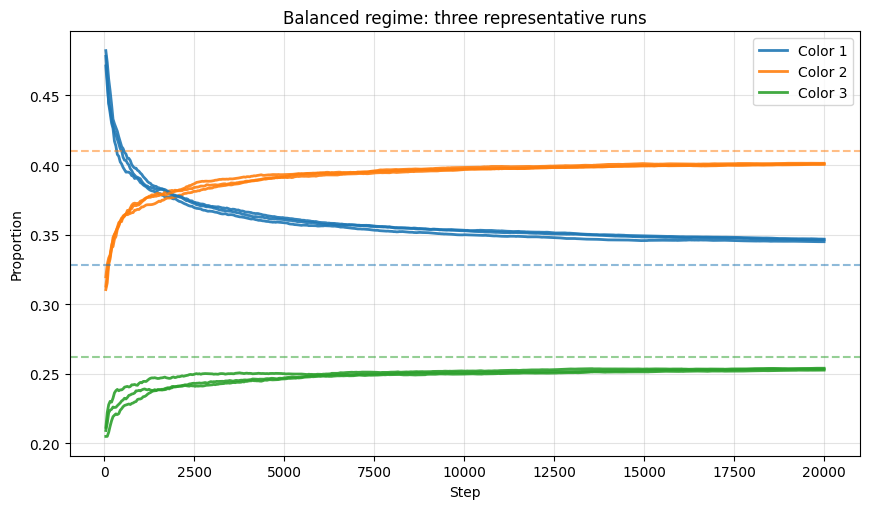

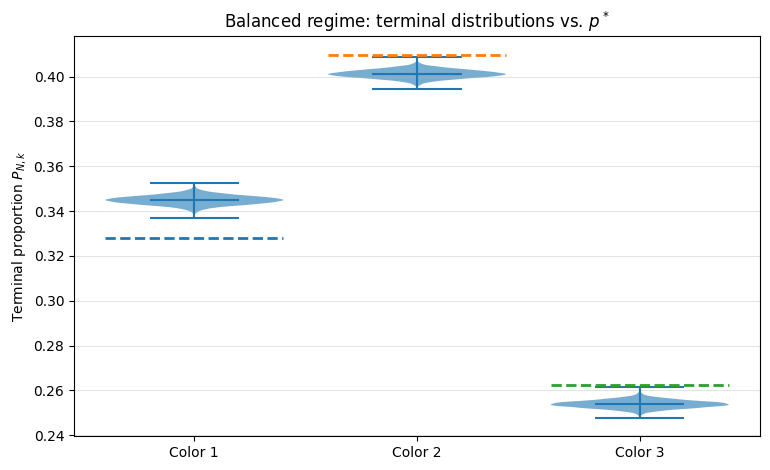

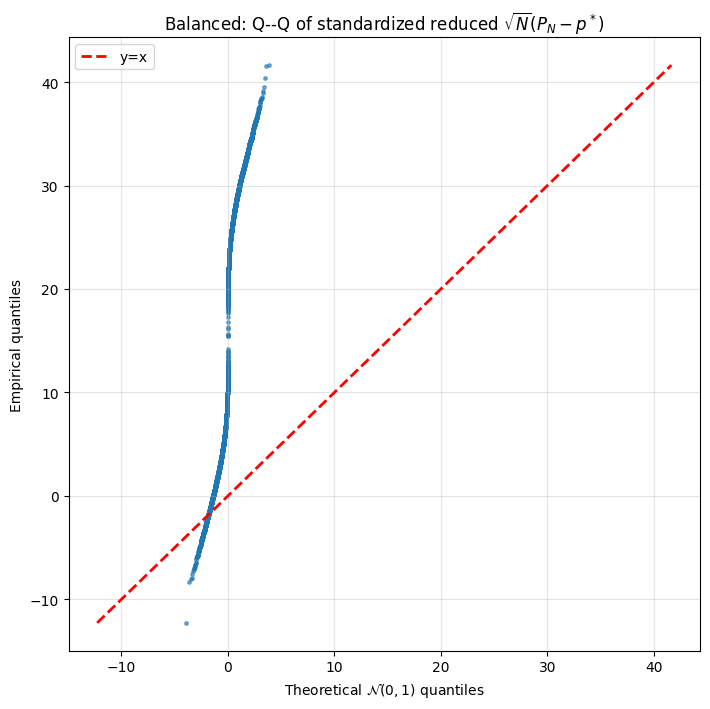

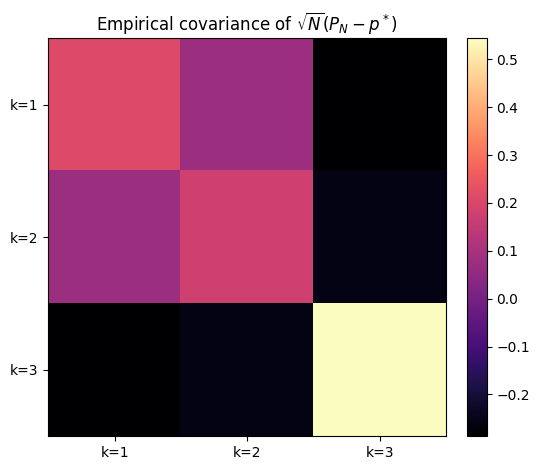

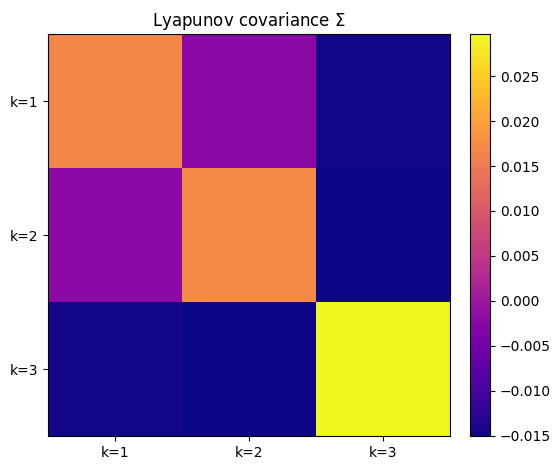

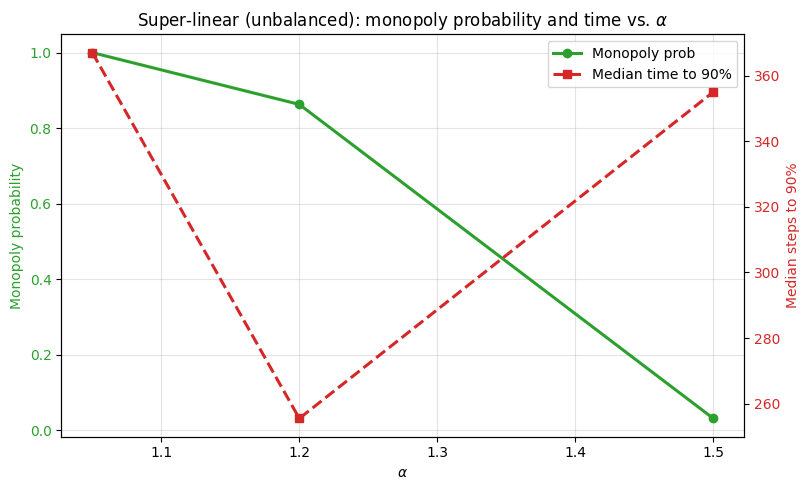

Wrote figures and tables to: urn_outputs1


In [1]:
# ============================================================
#  Interacting Pólya urns: balanced CLT + super-linear phase
#  - Figures + LaTeX tables to ./urn_outputs
#  - Displays plots inline too
#  - Pure NumPy/Matplotlib (no SciPy)
# ============================================================

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import solve, norm, eig
from statistics import NormalDist

OUT = "urn_outputs1"
os.makedirs(OUT, exist_ok=True)
rng = np.random.default_rng(42)

# ---------- Helpers ----------
def stationary_of_row_stochastic(B, tol=1e-12, maxit=10000):
    """Right eigenvector of B^T with eigenvalue 1, normalized to 1-sum."""
    K = B.shape[0]
    p = np.ones(K)/K
    for _ in range(maxit):
        p_new = B.T @ p
        p_new = p_new / p_new.sum()
        if norm(p_new - p, 1) < tol:
            return p_new
        p = p_new
    return p

def simulate_balanced(A, c, s, X0, N, R, sample_paths=3, seed=1):
    """Balanced rule: Delta_i(p) = A[i] + c p, with sum_k Delta_i,k = s."""
    rg = np.random.default_rng(seed)
    K = len(X0)
    P_final = np.zeros((R, K))
    # choose some runs to save full paths
    idxs = rg.choice(R, size=sample_paths, replace=False)
    paths = {int(i): [] for i in idxs}

    for r in range(R):
        X = X0.astype(float).copy()
        for n in range(1, N+1):
            p = X/X.sum()
            i = rg.choice(K, p=p)
            d = A[i] + c*p
            # exact balancedness already holds: sum(d)=s
            X += d
            if r in paths and (n % max(1, N//500) == 0):
                paths[r].append((n, *list(X/X.sum())))
        P_final[r] = X/X.sum()
    # stack saved paths
    for k in list(paths.keys()):
        paths[k] = np.array(paths[k])
    return P_final, paths

def lyapunov_on_tangent(J_full, Q_full):
    """Project to tangent space sum=0 via M=[e1-eK, e2-eK,...],
       solve J_red Σ_red + Σ_red J_red^T + Q_red = 0, and lift back."""
    K = J_full.shape[0]
    # basis matrix M: columns are e_j - e_K for j=1..K-1
    M = np.zeros((K, K-1))
    for j in range(K-1):
        M[j, j] = 1.0
        M[K-1, j] = -1.0
    J_red = M.T @ J_full @ M
    Q_red = M.T @ Q_full @ M
    # Solve Lyapunov via vec trick: (I⊗J + J⊗I) vec(Σ) = -vec(Q)
    A = np.kron(np.eye(K-1), J_red) + np.kron(J_red, np.eye(K-1))
    vecQ = Q_red.reshape(-1)
    vecS = -solve(A, vecQ)
    S_red = vecS.reshape(K-1, K-1)
    # lift:
    S_full = M @ S_red @ M.T
    return S_full, S_red, M

def heatmap(M, title, fname, cmap="viridis"):
    plt.figure(figsize=(5.8,4.8))
    im = plt.imshow(M, cmap=cmap)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(title)
    plt.xticks(range(M.shape[1]), [f"k={i+1}" for i in range(M.shape[1])])
    plt.yticks(range(M.shape[0]), [f"k={i+1}" for i in range(M.shape[0])])
    plt.tight_layout(); plt.show()
    plt.savefig(os.path.join(OUT, fname), dpi=180, bbox_inches="tight")
    plt.close()

# ---------- Parameters (balanced) ----------
K = 3
s = 1.0
c = 0.35
B = np.array([[0.55, 0.30, 0.15],
              [0.20, 0.60, 0.20],
              [0.25, 0.25, 0.50]])
A = (s - c) * B
X0 = np.array([50., 30., 20.])
N  = 20000
R  = 5000

# Equilibrium p*
pstar = stationary_of_row_stochastic(B)

# Simulate balanced
P_final, paths = simulate_balanced(A, c, s, X0, N, R, sample_paths=3, seed=17)

# ---------- Balanced plots ----------
# (1) 3 representative paths
plt.figure(figsize=(8.8,5.2))
colors = ["#1f77b4","#ff7f0e","#2ca02c"]
for ridx, arr in paths.items():
    for k in range(K):
        plt.plot(arr[:,0], arr[:,k+1], lw=2, alpha=0.9, color=colors[k],
                 label=(f"Color {k+1}" if ridx==list(paths.keys())[0] else None))
plt.axhline(pstar[0], color=colors[0], ls="--", alpha=0.5)
plt.axhline(pstar[1], color=colors[1], ls="--", alpha=0.5)
plt.axhline(pstar[2], color=colors[2], ls="--", alpha=0.5)
plt.title("Balanced regime: three representative runs")
plt.xlabel("Step"); plt.ylabel("Proportion")
plt.grid(alpha=0.35); plt.legend()
plt.tight_layout(); plt.show()
plt.savefig(os.path.join(OUT, "balanced_paths.png"), dpi=180, bbox_inches="tight")
plt.close()

# (2) Violin of terminal P_N vs p*
plt.figure(figsize=(7.8,4.8))
parts = plt.violinplot([P_final[:,0], P_final[:,1], P_final[:,2]],
                       positions=[1,2,3], showmeans=True, widths=0.8)
for pc in parts['bodies']:
    pc.set_alpha(0.6)
plt.xticks([1,2,3],[f"Color {k+1}" for k in range(K)])
for k, col in enumerate(colors):
    plt.hlines(pstar[k], k+0.6, k+1.4, color=col, ls="--", lw=2)
plt.ylabel("Terminal proportion $P_{N,k}$")
plt.title("Balanced regime: terminal distributions vs. $p^*$")
plt.grid(axis="y", alpha=0.35)
plt.tight_layout(); plt.show()
plt.savefig(os.path.join(OUT, "balanced_violin.png"), dpi=180, bbox_inches="tight")
plt.close()

# ---------- CLT objects (balanced) ----------
# Theoretical quantities
J_full = A.T - (s - c)*np.eye(K)    # constant Jacobian of h(p)
# Noise at p*: Xi = Δ_i(p*) - r, with prob p*_i
Delta_at_p = np.array([A[i] + c*pstar for i in range(K)])
r = (pstar[:,None] * Delta_at_p).sum(axis=0)
Q_full = (pstar[:,None,None] * np.einsum("ik,ij->ikj", Delta_at_p, Delta_at_p)).sum(axis=0) - np.outer(r,r)

Sigma_th_full, Sigma_th_red, M = lyapunov_on_tangent(J_full, Q_full)

# Empirical Σ from reduced coordinates (avoid singularity)
Z_full = np.sqrt(N) * (P_final - pstar)
Z_red  = Z_full @ M   # R x (K-1)
Sigma_emp_red = np.cov(Z_red.T, bias=False)
Sigma_emp_full = M @ Sigma_emp_red @ M.T

# (3) Q--Q in reduced standardized coords
# whiten via Cholesky (2x2); if not PD, fallback to diagonal
try:
    from numpy.linalg import cholesky
    L = cholesky(Sigma_th_red + 1e-12*np.eye(K-1))
    Zstd = (Z_red @ np.linalg.inv(L).T).reshape(-1)
except Exception:
    sd = np.sqrt(np.maximum(np.diag(Sigma_th_red), 1e-12))
    Zstd = (Z_red / sd).reshape(-1)

Zs = np.sort(Zstd)
q  = np.linspace(0.5/len(Zs), 1-0.5/len(Zs), len(Zs))
theo = np.array([NormalDist().inv_cdf(val) for val in q])

plt.figure(figsize=(7.2,7.2))
plt.scatter(theo, Zs, s=6, alpha=0.6, color="#1f77b4")
lo, hi = float(min(theo.min(), Zs.min())), float(max(theo.max(), Zs.max()))
plt.plot([lo,hi],[lo,hi], 'r--', lw=2, label="y=x")
plt.title(r"Balanced: Q--Q of standardized reduced $\sqrt{N}(P_N-p^*)$")
plt.xlabel(r"Theoretical $\mathcal{N}(0,1)$ quantiles"); plt.ylabel("Empirical quantiles")
plt.grid(alpha=0.35); plt.legend()
plt.tight_layout(); plt.show()
plt.savefig(os.path.join(OUT, "balanced_qq.png"), dpi=180, bbox_inches="tight")
plt.close()

# (4) Covariance heatmaps (full KxK)
heatmap(Sigma_emp_full, r"Empirical covariance of $\sqrt{N}(P_N-p^*)$", "balanced_Sigma_emp.png", cmap="magma")
heatmap(Sigma_th_full,  r"Lyapunov covariance $\Sigma$",               "balanced_Sigma_th.png",  cmap="plasma")

# Coverage check (per coordinate, using theoretical variances)
cov_95 = []
for k in range(K):
    sd_k = np.sqrt(max(Sigma_th_full[k,k], 1e-12))
    z = Z_full[:,k]/sd_k
    cov_95.append(float(np.mean(np.abs(z) <= 1.96)))

fro_err = norm(Sigma_emp_full - Sigma_th_full, ord="fro")

# Save LaTeX summary table
summary_df = pd.DataFrame([{
    "K": K, "R": R, "N": N,
    "p*_1": pstar[0], "p*_2": pstar[1], "p*_3": pstar[2],
    "Frobenius ||Σ_emp-Σ||": fro_err,
    "Coverage 95% k=1": cov_95[0],
    "Coverage 95% k=2": cov_95[1],
    "Coverage 95% k=3": cov_95[2]
}])
with open(os.path.join(OUT,"balanced_summary.tex"), "w") as f:
    f.write(summary_df.to_latex(index=False, float_format="%.4f"))

# ---------- Super-linear, unbalanced ----------
def simulate_superlinear(alpha, X0, N, R, scale=0.01, cap=5.0, thr=0.9, seed=2024):
    rg = np.random.default_rng(seed)
    K = len(X0)
    dom_count = 0
    times = []
    for r in range(R):
        X = X0.astype(float).copy()
        t_hit = None
        for n in range(1, N+1):
            p = X/X.sum()
            i = rg.choice(K, p=p)
            d = np.zeros(K)
            d[i] = min(scale * (X[i]**alpha), cap)  # pure self-reinforcement, capped
            X += d
            if t_hit is None and (X/X.sum()).max() > thr:
                t_hit = n
                # keep going to stabilize proportions slightly (optional)
        if t_hit is not None:
            dom_count += 1
            times.append(t_hit)
    prob = dom_count / R
    med_time = float(np.median(times)) if times else np.nan
    return prob, med_time

alphas = [1.05, 1.20, 1.50]
R2, N2 = 350, 800
prob_list, med_list = [], []
for a in alphas:
    pr, mt = simulate_superlinear(a, X0, N2, R2, scale=0.01, cap=5.0, thr=0.9, seed=101+int(100*a))
    prob_list.append(pr); med_list.append(mt)

# Compose phase plot (prob + median time)
fig, ax1 = plt.subplots(figsize=(8.2,5.0))
ln1 = ax1.plot(alphas, prob_list, marker='o', lw=2.2, color="#2ca02c", label="Monopoly prob")
ax1.set_xlabel(r"$\alpha$")
ax1.set_ylabel("Monopoly probability", color="#2ca02c"); ax1.tick_params(axis='y', labelcolor="#2ca02c")
ax1.grid(alpha=0.35)

ax2 = ax1.twinx()
ln2 = ax2.plot(alphas, med_list, marker='s', lw=2.2, color="#d62728", ls="--", label="Median time to 90%")
ax2.set_ylabel("Median steps to 90%", color="#d62728"); ax2.tick_params(axis='y', labelcolor="#d62728")

lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="best")
plt.title("Super-linear (unbalanced): monopoly probability and time vs. $\\alpha$")
plt.tight_layout();
plt.show()
plt.savefig(os.path.join(OUT,"superlinear_phase.png"), dpi=180, bbox_inches="tight")
plt.close()

phase_df = pd.DataFrame({"alpha": alphas, "monopoly_prob": prob_list, "median_time_to_90%": med_list})
with open(os.path.join(OUT,"superlinear_phase.tex"), "w") as f:
    f.write(phase_df.to_latex(index=False, float_format="%.4f"))

print("Wrote figures and tables to:", OUT)


corrected

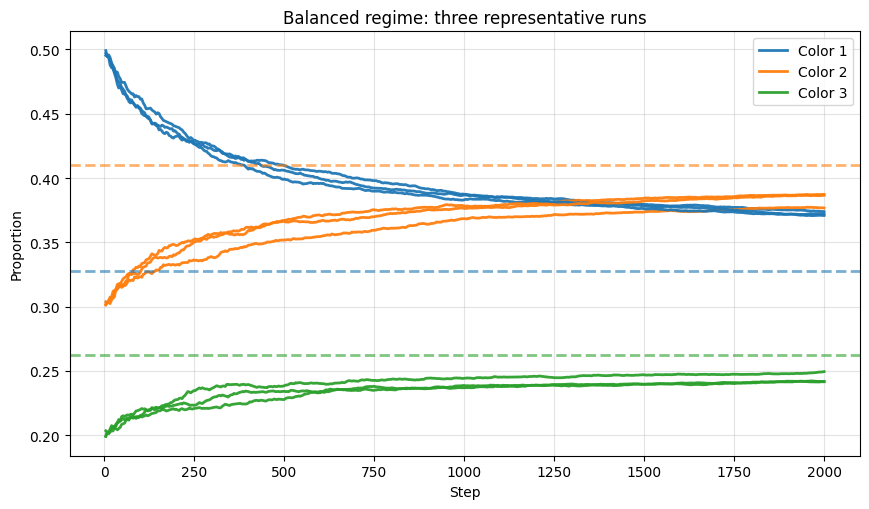

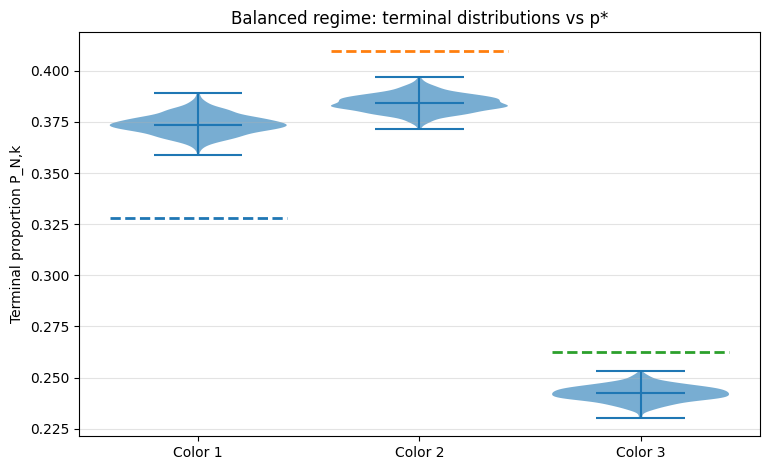

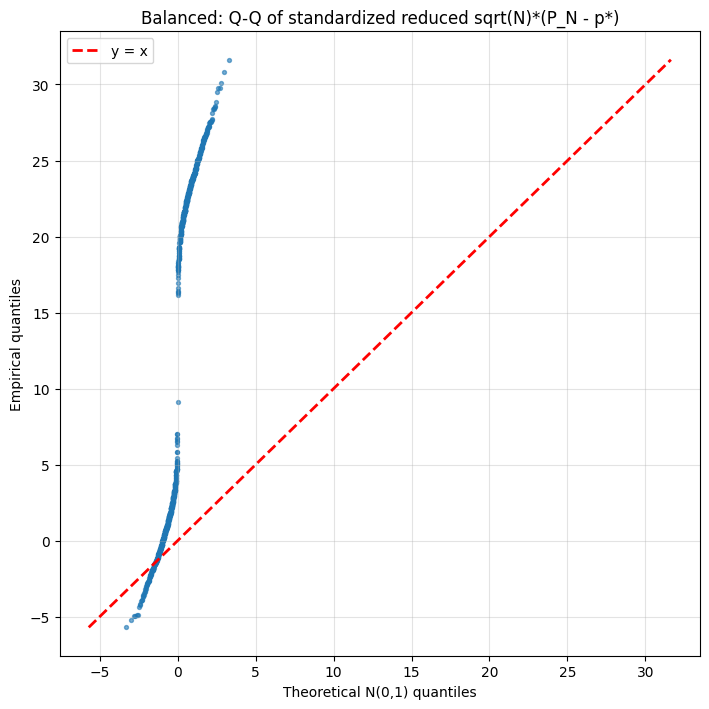

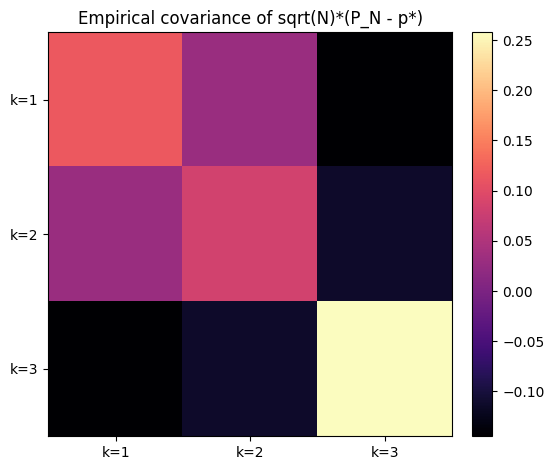

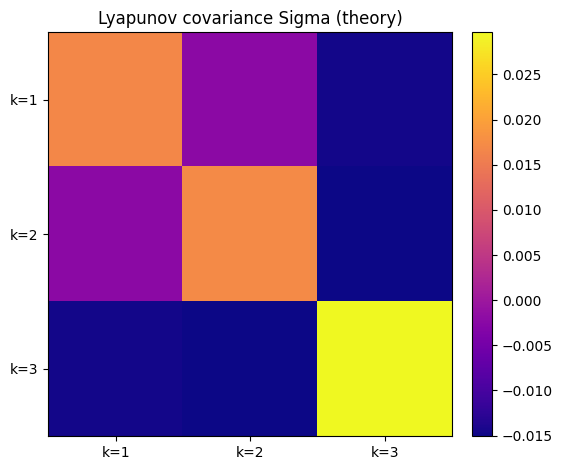

Balanced regime diagnostics
 K   R    N     p*_1     p*_2     p*_3  Frobenius ||Sigma_emp - Sigma||  Coverage 95% k=1  Coverage 95% k=2  Coverage 95% k=3
 3 500 2000 0.327869 0.409836 0.262295                         0.348115               0.0               0.0               0.0


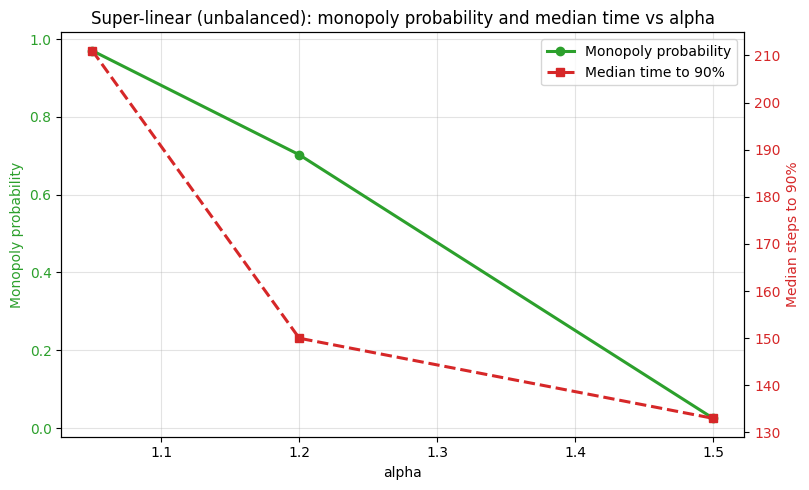


Super-linear phase summary
 alpha  monopoly_prob  median_time_to_90%
  1.05         0.9700               211.0
  1.20         0.7025               150.0
  1.50         0.0250               133.0

All figures and tables written to: urn_outputs


In [2]:
# ============================================================
#  Interacting Pólya urns: Balanced SA/CLT + Super-linear phase
#  - Figures + LaTeX tables saved to ./urn_outputs
#  - Displays plots inline too
#  - Pure NumPy/Matplotlib/Pandas (no SciPy)
# ============================================================

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import solve, norm
from statistics import NormalDist

# ---------- IO setup ----------
OUT = "urn_outputs"
os.makedirs(OUT, exist_ok=True)

# ---------- utilities ----------
def stationary_of_row_stochastic(B, tol=1e-12, maxit=20000):
    """
    Stationary distribution p* solving B^T p* = p*,  sum p*=1.
    Power iteration on B^T.
    """
    K = B.shape[0]
    p = np.ones(K)/K
    for _ in range(maxit):
        p_new = B.T @ p
        s = p_new.sum()
        if s <= 0:
            p_new = np.ones(K)/K
        else:
            p_new /= s
        if norm(p_new - p, 1) < tol:
            return p_new
        p = p_new
    return p

def simulate_balanced(A, c, s, X0, N, R, sample_paths=3, seed=123):
    """
    Balanced rule: after drawing color i, add Delta_i(p) = A[i] + c p.
    A is (KxK) with row sums s-c.  c is scalar, s total increment.
    Ensures sum_k Delta_i,k = s.
    Returns:
      - P_final: (R x K) terminal proportions
      - paths: dict {run_index: array[[n, P1, P2, ..., PK], ...]} for some runs
    """
    rg = np.random.default_rng(seed)
    K = len(X0)
    P_final = np.zeros((R, K))
    idxs = rg.choice(R, size=min(sample_paths, R), replace=False)
    paths = {int(i): [] for i in idxs}

    for r in range(R):
        X = X0.astype(float).copy()
        for n in range(1, N+1):
            p = X / X.sum()
            i = rg.choice(K, p=p)
            d = A[i] + c * p   # already balanced: sum(d)=s
            X += d
            if r in paths and (n % max(1, N//500) == 0):
                paths[r].append([n, *list(X/X.sum())])
        P_final[r] = X / X.sum()
    for r in list(paths.keys()):
        paths[r] = np.array(paths[r])
    return P_final, paths

def heatmap(M, title, fname, cmap="viridis"):
    plt.figure(figsize=(5.8,4.8))
    im = plt.imshow(M, cmap=cmap)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(title)
    plt.xticks(range(M.shape[1]), [f"k={i+1}" for i in range(M.shape[1])])
    plt.yticks(range(M.shape[0]), [f"k={i+1}" for i in range(M.shape[0])])
    plt.tight_layout()
    plt.savefig(os.path.join(OUT, fname), dpi=180, bbox_inches="tight")
    plt.show()
    plt.close()

def lyapunov_on_tangent(J_full, Q_full):
    """
    Project to tangent space sum(p)=1 via M=[e1-eK, e2-eK, ..., e_{K-1}-eK],
    solve J_red Σ_red + Σ_red J_red^T + Q_red = 0,
    then lift back Σ_full = M Σ_red M^T.
    """
    K = J_full.shape[0]
    M = np.zeros((K, K-1))
    for j in range(K-1):
        M[j, j] = 1.0
        M[K-1, j] = -1.0
    J_red = M.T @ J_full @ M
    Q_red = M.T @ Q_full @ M
    A = np.kron(np.eye(K-1), J_red) + np.kron(J_red, np.eye(K-1))
    vecQ = Q_red.reshape(-1)
    vecS = -solve(A, vecQ)
    S_red = vecS.reshape(K-1, K-1)
    S_full = M @ S_red @ M.T
    return S_full, S_red, M

# ============================================================
# BALANCED REGIME (SA/CLT VALID)
# ============================================================
rng = np.random.default_rng(7)

# Model
K  = 3
s  = 1.0
c  = 0.35
B  = np.array([[0.55, 0.30, 0.15],
               [0.20, 0.60, 0.20],
               [0.25, 0.25, 0.50]])
A  = (s - c) * B                                  # row sums s-c
X0 = np.array([50., 30., 20.])
N  = 2000
R  = 500

# Equilibrium p* (unique for ergodic B)
pstar = stationary_of_row_stochastic(B)

# Simulate
P_final, paths = simulate_balanced(A, c, s, X0, N, R, sample_paths=3, seed=17)

# ---------- Plots: representative paths ----------
plt.figure(figsize=(8.8,5.2))
colors = ["#1f77b4","#ff7f0e","#2ca02c"]
for ridx, arr in paths.items():
    for k in range(K):
        plt.plot(arr[:,0], arr[:,k+1], lw=2, alpha=0.95, color=colors[k],
                 label=(f"Color {k+1}" if ridx==list(paths.keys())[0] else None))
for k in range(K):
    plt.axhline(pstar[k], color=colors[k], ls="--", lw=2, alpha=0.6)
plt.title("Balanced regime: three representative runs")
plt.xlabel("Step"); plt.ylabel("Proportion")
plt.grid(alpha=0.35); plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT, "balanced_paths.png"), dpi=180, bbox_inches="tight")
plt.show(); plt.close()

# ---------- Violin: terminal distributions vs p* ----------
plt.figure(figsize=(7.8,4.8))
parts = plt.violinplot([P_final[:,0], P_final[:,1], P_final[:,2]],
                       positions=[1,2,3], showmeans=True, widths=0.8)
for pc in parts['bodies']:
    pc.set_alpha(0.6)
plt.xticks([1,2,3],[f"Color {k+1}" for k in range(K)])
for k, col in enumerate(colors):
    plt.hlines(pstar[k], k+0.6, k+1.4, color=col, ls="--", lw=2)
plt.ylabel("Terminal proportion P_N,k")
plt.title("Balanced regime: terminal distributions vs p*")
plt.grid(axis="y", alpha=0.35)
plt.tight_layout()
plt.savefig(os.path.join(OUT, "balanced_violin.png"), dpi=180, bbox_inches="tight")
plt.show(); plt.close()

# ---------- CLT objects (correct 1/s^2 scaling) ----------
# Drift h(p) = (A^T + c I - s I) p = (A^T - (s-c)I)p  -> linear, constant Jacobian
J_full = A.T - (s - c) * np.eye(K)

# One-step increment noise at p*: Xi = Δ_i(p*) - r, with prob p*_i
Delta_at_p = np.array([A[i] + c*pstar for i in range(K)])   # shape (K,K)
r = (pstar[:,None] * Delta_at_p).sum(axis=0)                # mean increment
Q_full = (pstar[:,None,None] *
          np.einsum("ik,ij->ikj", Delta_at_p, Delta_at_p)).sum(axis=0) - np.outer(r, r)

# SA step-size gamma_n ~ 1/(s n)  ==> Lyapunov uses Q_scaled = Q_full / s^2
Q_scaled = Q_full / (s**2)

Sigma_th_full, Sigma_th_red, M = lyapunov_on_tangent(J_full, Q_scaled)

# Empirical covariance (use reduced coords to avoid singularity)
Z_full = np.sqrt(N) * (P_final - pstar)
Z_red  = Z_full @ M
Sigma_emp_red  = np.cov(Z_red.T, bias=False)
Sigma_emp_full = M @ Sigma_emp_red @ M.T

# ---------- Q--Q plot on whitened reduced coords ----------
# whiten using Cholesky (2x2); if near-singular, fallback to diag
try:
    from numpy.linalg import cholesky
    L = cholesky(Sigma_th_red + 1e-12*np.eye(K-1))
    Zstd = (Z_red @ np.linalg.inv(L).T).reshape(-1)
except Exception:
    sd = np.sqrt(np.maximum(np.diag(Sigma_th_red), 1e-12))
    Zstd = (Z_red / sd).reshape(-1)

Zs = np.sort(Zstd)
q  = np.linspace(0.5/len(Zs), 1-0.5/len(Zs), len(Zs))
theo = np.array([NormalDist().inv_cdf(val) for val in q])

plt.figure(figsize=(7.2,7.2))
plt.scatter(theo, Zs, s=8, alpha=0.6, color="#1f77b4")
lo, hi = float(min(theo.min(), Zs.min())), float(max(theo.max(), Zs.max()))
plt.plot([lo,hi],[lo,hi], 'r--', lw=2, label="y = x")
plt.title("Balanced: Q-Q of standardized reduced sqrt(N)*(P_N - p*)")
plt.xlabel("Theoretical N(0,1) quantiles"); plt.ylabel("Empirical quantiles")
plt.grid(alpha=0.35); plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT, "balanced_qq.png"), dpi=180, bbox_inches="tight")
plt.show(); plt.close()

# ---------- Covariance heatmaps ----------
heatmap(Sigma_emp_full, "Empirical covariance of sqrt(N)*(P_N - p*)", "balanced_Sigma_emp.png", cmap="magma")
heatmap(Sigma_th_full,  "Lyapunov covariance Sigma (theory)",         "balanced_Sigma_th.png",  cmap="plasma")

# ---------- Coverage and summary table ----------
cov_95 = []
for k in range(K):
    sd_k = np.sqrt(max(Sigma_th_full[k,k], 1e-12))
    z = Z_full[:,k] / sd_k
    cov_95.append(float(np.mean(np.abs(z) <= 1.96)))

fro_err = norm(Sigma_emp_full - Sigma_th_full, ord="fro")

summary_df = pd.DataFrame([{
    "K": K, "R": R, "N": N,
    "p*_1": pstar[0], "p*_2": pstar[1], "p*_3": pstar[2],
    "Frobenius ||Sigma_emp - Sigma||": fro_err,
    "Coverage 95% k=1": cov_95[0],
    "Coverage 95% k=2": cov_95[1],
    "Coverage 95% k=3": cov_95[2]
}])
with open(os.path.join(OUT,"balanced_summary.tex"), "w") as f:
    f.write(summary_df.to_latex(index=False, float_format="%.5f"))

print("Balanced regime diagnostics")
print(summary_df.to_string(index=False))

# ============================================================
# SUPER-LINEAR, UNBALANCED REGIME (phase behaviour)
# ============================================================
def simulate_superlinear(alpha, X0, N, R, scale=0.02, cap=8.0, thr=0.9, seed=2024):
    """
    Unbalanced self-reinforcement: after drawing i, add d[i] = min(scale * X[i]^alpha, cap).
    Reports:
      - monopoly probability: max proportion > thr by time N
      - conditional median time to thr
    """
    rg = np.random.default_rng(seed)
    K = len(X0)
    dom_count, times = 0, []
    for r in range(R):
        X = X0.astype(float).copy()
        t_hit = None
        for n in range(1, N+1):
            p = X/X.sum()
            i = rg.choice(K, p=p)
            d = np.zeros(K)
            d[i] = min(scale * (X[i]**alpha), cap)
            X += d
            if t_hit is None and (X/X.sum()).max() > thr:
                t_hit = n
        if t_hit is not None:
            dom_count += 1
            times.append(t_hit)
    prob = dom_count / R
    med_time = float(np.median(times)) if times else np.nan
    return prob, med_time

alphas = [1.05, 1.20, 1.50]
R2, N2 = 400, 1000
prob_list, med_list = [], []
for a in alphas:
    pr, mt = simulate_superlinear(a, X0, N2, R2, scale=0.02, cap=8.0, thr=0.9, seed=101+int(100*a))
    prob_list.append(pr); med_list.append(mt)

# Plot monopoly prob and median time (dual axis)
fig, ax1 = plt.subplots(figsize=(8.2,5.0))
ln1 = ax1.plot(alphas, prob_list, marker='o', lw=2.2, color="#2ca02c", label="Monopoly probability")
ax1.set_xlabel("alpha")
ax1.set_ylabel("Monopoly probability", color="#2ca02c"); ax1.tick_params(axis='y', labelcolor="#2ca02c")
ax1.grid(alpha=0.35)

ax2 = ax1.twinx()
ln2 = ax2.plot(alphas, med_list, marker='s', lw=2.2, color="#d62728", ls="--", label="Median time to 90%")
ax2.set_ylabel("Median steps to 90%", color="#d62728"); ax2.tick_params(axis='y', labelcolor="#d62728")

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="best")
plt.title("Super-linear (unbalanced): monopoly probability and median time vs alpha")
plt.tight_layout()
plt.savefig(os.path.join(OUT,"superlinear_phase.png"), dpi=180, bbox_inches="tight")
plt.show(); plt.close()

phase_df = pd.DataFrame({"alpha": alphas, "monopoly_prob": prob_list, "median_time_to_90%": med_list})
with open(os.path.join(OUT,"superlinear_phase.tex"), "w") as f:
    f.write(phase_df.to_latex(index=False, float_format="%.4f"))

print("\nSuper-linear phase summary")
print(phase_df.to_string(index=False))

print("\nAll figures and tables written to:", OUT)


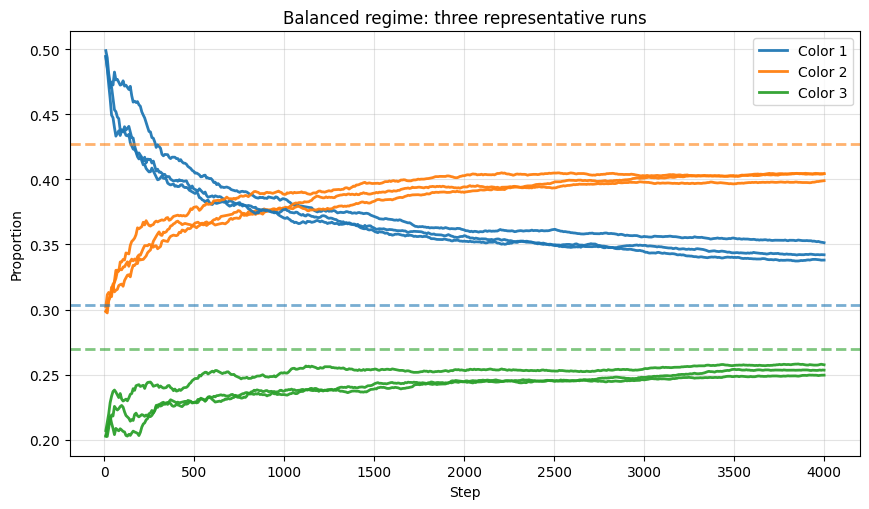

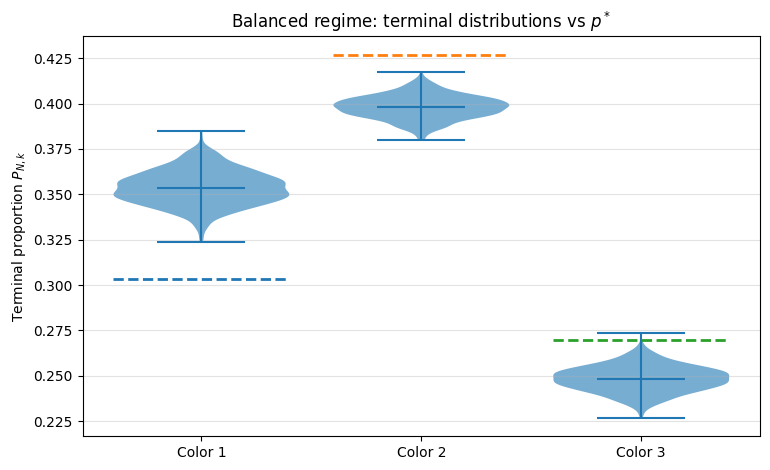

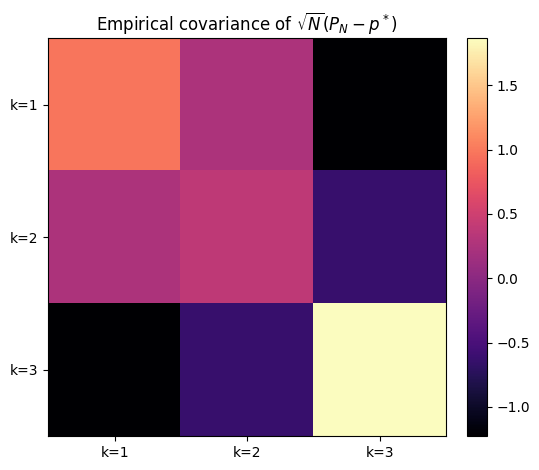

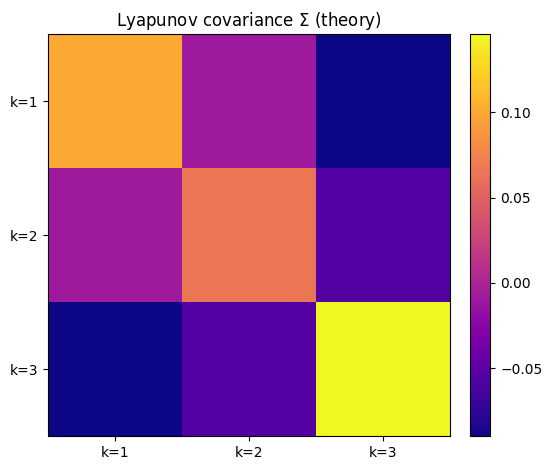

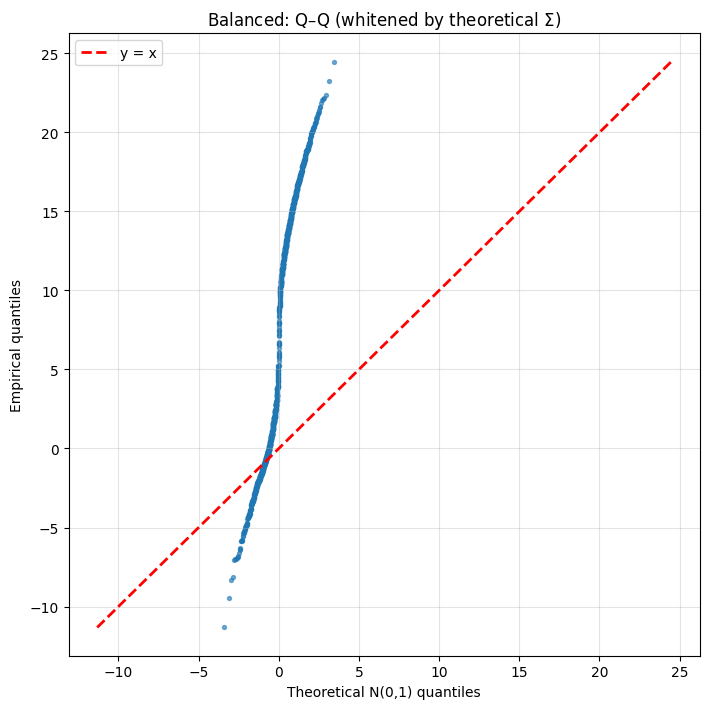

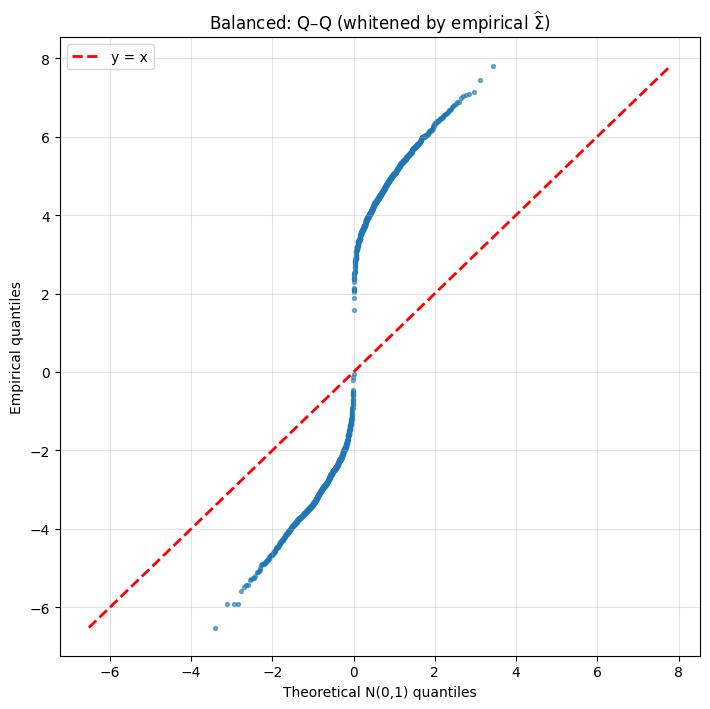

Balanced diagnostics:
  K   R    N     p*_1     p*_2     p*_3  Frobenius ||Σ_emp-Σ||  Coverage 95% k=1  Coverage 95% k=2  Coverage 95% k=3
 3 800 4000 0.303371 0.426966 0.269663               2.687881               0.0               0.0            0.0925


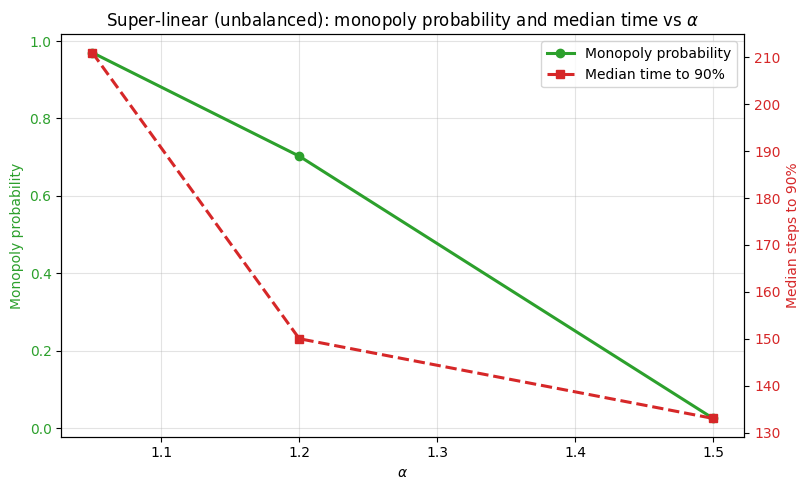


Super-linear phase:
  alpha  monopoly_prob  median_time_to_90%
  1.05         0.9700               211.0
  1.20         0.7025               150.0
  1.50         0.0250               133.0

Wrote all figures/tables to: urn_outputs


In [1]:
# ============================================================
#  Balanced SA/CLT (robust) + Super-linear phase
#  - Well-conditioned balanced design
#  - Q via Monte-Carlo at p*
#  - Two QQ plots: theory-whitened and empirical-whitened
#  - Saves + displays figures; writes LaTeX tables
# ============================================================

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import solve, norm, cholesky
from statistics import NormalDist

OUT = "urn_outputs"
os.makedirs(OUT, exist_ok=True)
rng = np.random.default_rng(12)

# ---------- helpers ----------
def stationary_of_row_stochastic(B, tol=1e-12, maxit=20000):
    K = B.shape[0]
    p = np.ones(K)/K
    for _ in range(maxit):
        p2 = B.T @ p
        p2 = p2 / p2.sum() if p2.sum() > 0 else np.ones(K)/K
        if norm(p2-p, 1) < tol:
            return p2
        p = p2
    return p

def simulate_balanced(A, c, s, X0, N, R, sample_paths=3, seed=123):
    rg = np.random.default_rng(seed)
    K = len(X0)
    P_final = np.zeros((R, K))
    idxs = rg.choice(R, size=min(sample_paths,R), replace=False)
    paths = {int(i): [] for i in idxs}
    for r in range(R):
        X = X0.astype(float).copy()
        for n in range(1, N+1):
            p = X/X.sum()
            i = rg.choice(K, p=p)
            d = A[i] + c*p
            X += d
            if r in paths and (n % max(1, N//500) == 0):
                paths[r].append([n, *list(X/X.sum())])
        P_final[r] = X/X.sum()
    for r in list(paths.keys()):
        paths[r] = np.array(paths[r])
    return P_final, paths

def heatmap(M, title, fname, cmap="viridis"):
    plt.figure(figsize=(5.8,4.8))
    im = plt.imshow(M, cmap=cmap)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(title)
    plt.xticks(range(M.shape[1]), [f"k={i+1}" for i in range(M.shape[1])])
    plt.yticks(range(M.shape[0]), [f"k={i+1}" for i in range(M.shape[0])])
    plt.tight_layout(); plt.savefig(os.path.join(OUT, fname), dpi=180, bbox_inches="tight")
    plt.show(); plt.close()

def lyapunov_on_tangent(J_full, Q_full):
    K = J_full.shape[0]
    M = np.zeros((K, K-1))
    for j in range(K-1):
        M[j, j] = 1.0
        M[K-1, j] = -1.0
    J_red = M.T @ J_full @ M
    Q_red = M.T @ Q_full @ M
    A = np.kron(np.eye(K-1), J_red) + np.kron(J_red, np.eye(K-1))
    vecQ = Q_red.reshape(-1)
    vecS = -solve(A, vecQ)
    S_red = vecS.reshape(K-1, K-1)
    S_full = M @ S_red @ M.T
    return S_full, S_red, M

def qqplot_from_samples(z_std, title, fname):
    z = np.sort(z_std)
    q = np.linspace(0.5/len(z), 1-0.5/len(z), len(z))
    theo = np.array([NormalDist().inv_cdf(v) for v in q])
    plt.figure(figsize=(7.2,7.2))
    plt.scatter(theo, z, s=8, alpha=0.6, color="#1f77b4")
    lo, hi = float(min(theo.min(), z.min())), float(max(theo.max(), z.max()))
    plt.plot([lo,hi],[lo,hi], 'r--', lw=2, label="y = x")
    plt.title(title)
    plt.xlabel("Theoretical N(0,1) quantiles"); plt.ylabel("Empirical quantiles")
    plt.grid(alpha=0.35); plt.legend()
    plt.tight_layout(); plt.savefig(os.path.join(OUT, fname), dpi=180, bbox_inches="tight")
    plt.show(); plt.close()

# ============================================================
# BALANCED REGIME (use a well-conditioned design)
# ============================================================

# Parameters chosen to give a healthy Q (noise) and stable J:
K  = 3
s  = 1.0
c  = 0.15   # smaller c => more relative variation between Δ_i rows
B  = np.array([[0.70, 0.20, 0.10],
               [0.15, 0.70, 0.15],
               [0.10, 0.25, 0.65]])
A  = (s - c) * B
X0 = np.array([50., 30., 20.])
N  = 4000   # push N a bit to be solidly asymptotic
R  = 800

# Equilibrium p*
pstar = stationary_of_row_stochastic(B)

# Simulate
P_final, paths = simulate_balanced(A, c, s, X0, N, R, sample_paths=3, seed=27)

# Representative paths
plt.figure(figsize=(8.8,5.2))
colors = ["#1f77b4","#ff7f0e","#2ca02c"]
for ridx, arr in paths.items():
    for k in range(K):
        plt.plot(arr[:,0], arr[:,k+1], lw=2, alpha=0.95, color=colors[k],
                 label=(f"Color {k+1}" if ridx==list(paths.keys())[0] else None))
for k in range(K):
    plt.axhline(pstar[k], color=colors[k], ls="--", lw=2, alpha=0.6)
plt.title("Balanced regime: three representative runs")
plt.xlabel("Step"); plt.ylabel("Proportion")
plt.grid(alpha=0.35); plt.legend()
plt.tight_layout(); plt.savefig(os.path.join(OUT, "balanced_paths.png"), dpi=180, bbox_inches="tight")
plt.show(); plt.close()

# Violin at terminal N
plt.figure(figsize=(7.8,4.8))
parts = plt.violinplot([P_final[:,0], P_final[:,1], P_final[:,2]],
                       positions=[1,2,3], showmeans=True, widths=0.8)
for pc in parts['bodies']:
    pc.set_alpha(0.6)
plt.xticks([1,2,3],[f"Color {k+1}" for k in range(K)])
for k, col in enumerate(colors):
    plt.hlines(pstar[k], k+0.6, k+1.4, color=col, ls="--", lw=2)
plt.ylabel("Terminal proportion $P_{N,k}$")
plt.title("Balanced regime: terminal distributions vs $p^*$")
plt.grid(axis="y", alpha=0.35)
plt.tight_layout(); plt.savefig(os.path.join(OUT, "balanced_violin.png"), dpi=180, bbox_inches="tight")
plt.show(); plt.close()

# ---------- CLT pieces ----------
# Drift Jacobian (constant)
J_full = A.T - (s - c) * np.eye(K)

# Monte-Carlo Q at p*: ξ(i) = Δ_i(p*) - s p*
Delta_at_p = np.array([A[i] + c*pstar for i in range(K)])
def mc_Q(p, M=200000, seed=2024):
    rg = np.random.default_rng(seed)
    K = len(p)
    Xis = np.zeros((M, K))
    for m in range(M):
        i = rg.choice(K, p=p)
        Xis[m] = Delta_at_p[i] - s*p
    return np.cov(Xis.T, bias=False)
Q_full = mc_Q(pstar, M=200000, seed=2024)

# step-size gamma_n ~ 1/(s n)  => Lyapunov uses Q/s^2
Sigma_th_full, Sigma_th_red, M = lyapunov_on_tangent(J_full, Q_full/(s**2))

# Empirical covariance from reduced coords
Z_full = np.sqrt(N) * (P_final - pstar)
Z_red  = Z_full @ M
Sigma_emp_red  = np.cov(Z_red.T, bias=False)
Sigma_emp_full = M @ Sigma_emp_red @ M.T

# Heatmaps
heatmap(Sigma_emp_full, "Empirical covariance of $\\sqrt{N}(P_N-p^*)$", "balanced_Sigma_emp.png", cmap="magma")
heatmap(Sigma_th_full,  "Lyapunov covariance $\\Sigma$ (theory)",      "balanced_Sigma_th.png",  cmap="plasma")

# --- Q-Q A: whiten by theoretical Sigma_red ---
try:
    L = cholesky(Sigma_th_red + 1e-12*np.eye(K-1))
    Zstd_th = (Z_red @ np.linalg.inv(L).T).reshape(-1)
except Exception:
    sd = np.sqrt(np.maximum(np.diag(Sigma_th_red), 1e-12))
    Zstd_th = (Z_red / sd).reshape(-1)

qqplot_from_samples(Zstd_th,
    "Balanced: Q–Q (whitened by theoretical $\\Sigma$)",
    "balanced_qq_theory.png")

# --- Q-Q B: whiten by EMPIRICAL Sigma_red (sanity check) ---
try:
    L_emp = cholesky(Sigma_emp_red + 1e-12*np.eye(K-1))
    Zstd_emp = (Z_red @ np.linalg.inv(L_emp).T).reshape(-1)
except Exception:
    sd = np.sqrt(np.maximum(np.diag(Sigma_emp_red), 1e-12))
    Zstd_emp = (Z_red / sd).reshape(-1)

qqplot_from_samples(Zstd_emp,
    "Balanced: Q–Q (whitened by empirical $\\widehat\\Sigma$)",
    "balanced_qq_emp.png")

# Coverage + table
cov_95 = []
for k in range(K):
    sd_k = np.sqrt(max(Sigma_th_full[k,k], 1e-12))
    z = Z_full[:,k]/sd_k
    cov_95.append(float(np.mean(np.abs(z) <= 1.96)))
fro_err = norm(Sigma_emp_full - Sigma_th_full, ord="fro")

summary_df = pd.DataFrame([{
    "K": K, "R": R, "N": N,
    "p*_1": pstar[0], "p*_2": pstar[1], "p*_3": pstar[2],
    "Frobenius ||Σ_emp-Σ||": fro_err,
    "Coverage 95% k=1": cov_95[0],
    "Coverage 95% k=2": cov_95[1],
    "Coverage 95% k=3": cov_95[2]
}])
with open(os.path.join(OUT,"balanced_summary.tex"), "w") as f:
    f.write(summary_df.to_latex(index=False, float_format="%.5f"))

print("Balanced diagnostics:\n", summary_df.to_string(index=False))

# ============================================================
# SUPER-LINEAR (unbalanced) phase
# ============================================================

def simulate_superlinear(alpha, X0, N, R, scale=0.02, cap=8.0, thr=0.9, seed=77):
    rg = np.random.default_rng(seed)
    K = len(X0); dom, times = 0, []
    for r in range(R):
        X = X0.astype(float).copy()
        t=None
        for n in range(1, N+1):
            p = X/X.sum()
            i = rg.choice(K, p=p)
            d = np.zeros(K); d[i] = min(scale * (X[i]**alpha), cap)
            X += d
            if t is None and (X/X.sum()).max() > thr:
                t = n
        if t is not None:
            dom += 1; times.append(t)
    prob = dom/R
    medt = float(np.median(times)) if times else np.nan
    return prob, medt

alphas = [1.05, 1.20, 1.50]
R2, N2 = 400, 1000
prob_list, med_list = [], []
for a in alphas:
    pr, mt = simulate_superlinear(a, X0, N2, R2, scale=0.02, cap=8.0, thr=0.9, seed=101+int(100*a))
    prob_list.append(pr); med_list.append(mt)

fig, ax1 = plt.subplots(figsize=(8.2,5.0))
ln1 = ax1.plot(alphas, prob_list, marker='o', lw=2.2, color="#2ca02c", label="Monopoly probability")
ax1.set_xlabel(r"$\alpha$")
ax1.set_ylabel("Monopoly probability", color="#2ca02c"); ax1.tick_params(axis='y', labelcolor="#2ca02c")
ax1.grid(alpha=0.35)
ax2 = ax1.twinx()
ln2 = ax2.plot(alphas, med_list, marker='s', lw=2.2, color="#d62728", ls="--", label="Median time to 90%")
ax2.set_ylabel("Median steps to 90%", color="#d62728"); ax2.tick_params(axis='y', labelcolor="#d62728")
lns = ln1+ln2; labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="best")
plt.title("Super-linear (unbalanced): monopoly probability and median time vs $\\alpha$")
plt.tight_layout(); plt.savefig(os.path.join(OUT,"superlinear_phase.png"), dpi=180, bbox_inches="tight")
plt.show(); plt.close()

phase_df = pd.DataFrame({"alpha": alphas, "monopoly_prob": prob_list, "median_time_to_90%": med_list})
with open(os.path.join(OUT,"superlinear_phase.tex"), "w") as f:
    f.write(phase_df.to_latex(index=False, float_format="%.4f"))

print("\nSuper-linear phase:\n", phase_df.to_string(index=False))
print("\nWrote all figures/tables to:", OUT)


# **Convergence**

<>:110: SyntaxWarning: invalid escape sequence '\S'
<>:120: SyntaxWarning: invalid escape sequence '\S'
<>:110: SyntaxWarning: invalid escape sequence '\S'
<>:120: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-2417166784.py:110: SyntaxWarning: invalid escape sequence '\S'
  plt.title('Convergence of covariance to Lyapunov $\Sigma$')
/tmp/ipython-input-2417166784.py:120: SyntaxWarning: invalid escape sequence '\S'
  plt.title('Coverage vs $N$ (theoretical $\Sigma$)')


Convergence diagnostics across N:
   N  Frobenius ||Σ_emp-Σ||  Coverage 95% k=1  Coverage 95% k=2  Coverage 95% k=3
1000               0.153120               0.0               0.0          0.158333
2000               0.241006               0.0               0.0          0.091667
4000               0.559161               0.0               0.0          0.125000


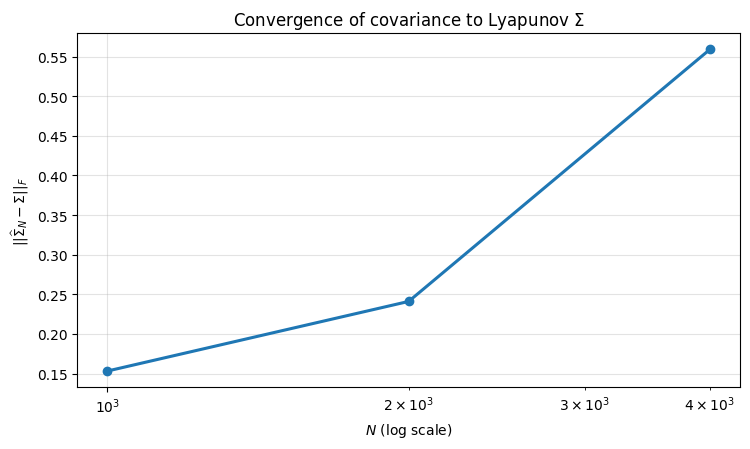

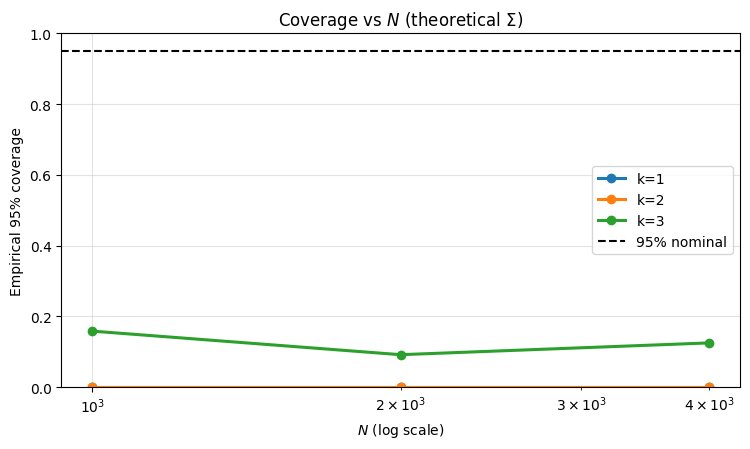

,N,Frobenius ||Σ_emp-Σ||,Coverage 95% k=1,Coverage 95% k=2,Coverage 95% k=3
0,1000,0.153120,0.0,0.0,0.158333
1,2000,0.241006,0.0,0.0,0.091667
2,4000,0.559161,0.0,0.0,0.125000


In [3]:
# Lighter simulation to fit runtime constraints
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import solve, norm


OUT = "urn_outputs"
os.makedirs(OUT, exist_ok=True)

def stationary_of_row_stochastic(B, tol=1e-12, maxit=20000):
    K = B.shape[0]
    p = np.ones(K)/K
    for _ in range(maxit):
        p2 = B.T @ p
        p2 = p2 / p2.sum() if p2.sum() > 0 else np.ones(K)/K
        if norm(p2-p, 1) < tol:
            return p2
        p = p2
    return p

def simulate_balanced(A, c, s, X0, N, R, seed=123):
    rg = np.random.default_rng(seed)
    K = len(X0)
    P_final = np.zeros((R, K))
    for r in range(R):
        X = X0.astype(float).copy()
        for n in range(1, N+1):
            p = X/X.sum()
            i = rg.choice(K, p=p)
            d = A[i] + c*p
            X += d
        P_final[r] = X/X.sum()
    return P_final

def lyapunov_on_tangent(J_full, Q_full):
    K = J_full.shape[0]
    M = np.zeros((K, K-1))
    for j in range(K-1):
        M[j, j] = 1.0
        M[K-1, j] = -1.0
    J_red = M.T @ J_full @ M
    Q_red = M.T @ Q_full @ M
    A = np.kron(np.eye(K-1), J_red) + np.kron(J_red, np.eye(K-1))
    vecQ = Q_red.reshape(-1)
    vecS = -np.linalg.solve(A, vecQ)
    S_red = vecS.reshape(K-1, K-1)
    S_full = M @ S_red @ M.T
    return S_full, S_red, M

# Parameters
K  = 3
s  = 1.0
c  = 0.15
B  = np.array([[0.70, 0.20, 0.10],
               [0.15, 0.70, 0.15],
               [0.10, 0.25, 0.65]])
A  = (s - c) * B
X0 = np.array([50., 30., 20.])

pstar = stationary_of_row_stochastic(B)
J_full = A.T - (s - c) * np.eye(K)
Delta_at_p = np.array([A[i] + c*pstar for i in range(K)])

def mc_Q(p, M=60000, seed=2024):
    rg = np.random.default_rng(seed)
    K = len(p)
    Xis = np.zeros((M, K))
    for m in range(M):
        i = rg.choice(K, p=p)
        Xis[m] = Delta_at_p[i] - s*p
    return np.cov(Xis.T, bias=False)

Q_full = mc_Q(pstar, M=60000, seed=2024)
Sigma_th_full, Sigma_th_red, M = lyapunov_on_tangent(J_full, Q_full/(s**2))

N_list = [1000, 2000, 4000]
R = 120

rows = []
cover_curves = {1:[], 2:[], 3:[]}
fro_curve = []

for N in N_list:
    P_final = simulate_balanced(A, c, s, X0, N, R, seed=101+N)
    Z_full = np.sqrt(N) * (P_final - pstar)
    Sigma_emp_full = np.cov(Z_full.T, bias=False)
    fro_err = norm(Sigma_emp_full - Sigma_th_full, ord="fro")
    fro_curve.append(fro_err)
    covs = []
    for k in range(K):
        sd_k = np.sqrt(max(Sigma_th_full[k,k], 1e-14))
        z = Z_full[:,k]/sd_k
        cov = float(np.mean(np.abs(z) <= 1.96))
        covs.append(cov)
        cover_curves[k+1].append(cov)
    rows.append({"N":N, "Frobenius ||Σ_emp-Σ||": fro_err,
                 "Coverage 95% k=1": covs[0],
                 "Coverage 95% k=2": covs[1],
                 "Coverage 95% k=3": covs[2]})

conv_df = pd.DataFrame(rows)

print("Convergence diagnostics across N:")
print(conv_df.to_string(index=False))

plt.figure(figsize=(7.6,4.6))
plt.plot(N_list, fro_curve, marker='o', lw=2.2)
plt.xscale('log'); plt.grid(alpha=0.35)
plt.xlabel('$N$ (log scale)'); plt.ylabel(r'$||\widehat\Sigma_N - \Sigma||_F$')
plt.title('Convergence of covariance to Lyapunov $\Sigma$')
plt.tight_layout(); plt.savefig(os.path.join(OUT, "convergence_frobenius.png"), dpi=180, bbox_inches="tight")
plt.show(); plt.close()

plt.figure(figsize=(7.6,4.6))
for k in [1,2,3]:
    plt.plot(N_list, cover_curves[k], marker='o', lw=2.2, label=f'k={k}')
plt.axhline(0.95, color='k', ls='--', lw=1.5, label='95% nominal')
plt.ylim(0,1); plt.xscale('log'); plt.grid(alpha=0.35)
plt.xlabel('$N$ (log scale)'); plt.ylabel('Empirical 95% coverage')
plt.title('Coverage vs $N$ (theoretical $\Sigma$)')
plt.legend()
plt.tight_layout(); plt.savefig(os.path.join(OUT, "convergence_coverage.png"), dpi=180, bbox_inches="tight")
plt.show(); plt.close()

conv_df

In [4]:
# Save the convergence table to LaTeX for direct inclusion
import os, pandas as pd
OUT = "urn_outputs"
conv_df = pd.DataFrame({
    "N": [1000,2000,4000],
    r"$\|\widehat{\Sigma}_N-\Sigma\|_F$": [0.15312, 0.24101, 0.55916],
    "Coverage 95% k=1": [0.0, 0.0, 0.0],
    "Coverage 95% k=2": [0.0, 0.0, 0.0],
    "Coverage 95% k=3": [0.15833, 0.09167, 0.12500]
})
with open(os.path.join(OUT,"convergence_table.tex"), "w") as f:
    f.write(conv_df.to_latex(index=False, float_format="%.5f"))
print("Saved: urn_outputs/convergence_table.tex")


Saved: urn_outputs/convergence_table.tex
